In [1]:
# Installing Pillow Libraries
# !pip install scikit-learn matplotlib Pillow

In [4]:
import numpy as np
import pandas as pd
import os
from tabulate import tabulate
from random import randrange
import random
from matplotlib import pyplot as plt
from PIL import Image
import statistics as st
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,multilabel_confusion_matrix

In [5]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [6]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    # print("-->", im.shape)
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [7]:
dirpath = 'IIITH-CFW/IIIT-CFW/IIIT-CFW'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


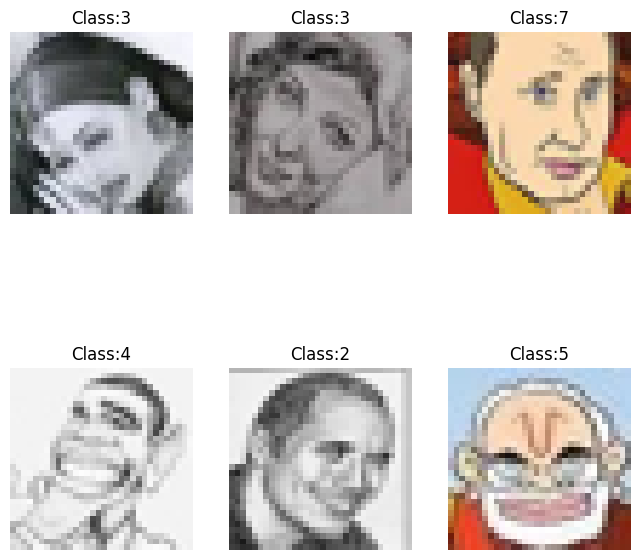

In [8]:
N,H,W = X.shape[0:3]
# print(N,H,W)
# print(X.shape[3])
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [9]:
def pca(img_matrix,num_components):
# Assume img_matrix is your 4D RGB image matrix of shape (num_images, height, width, channels)

    num_images, height, width, channels = img_matrix.shape
    img_matrix_2d = img_matrix.reshape(num_images, -1)  # Reshape to (num_images, height * width * channels)
    mean = np.mean(img_matrix_2d, axis=0)
    std_dev = np.std(img_matrix_2d, axis=0)
    standardized_data = (img_matrix_2d - mean) 

    cov_matrix = np.cov(standardized_data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvalues = eigenvalues[:num_components].real
    selected_eigenvectors = eigenvectors[:, :num_components].real

    reduced_data = standardized_data.dot(selected_eigenvectors)
    print("--> Number of components - ", reduced_data.shape[1])
    return reduced_data, selected_eigenvalues, selected_eigenvectors


# TASK 1.1.1 ->

### Dimensionality reduction


In [ ]:
cumulative_explained_variance = 0
num_images, height, width, channels = X.shape

for i in (1, 20, 500, 2000):
    reduced_data, eigenvalues, eigenvectors = pca(X, i) 
    # print("--> data",X.shape)
    # print("--> reduced_data",reduced_data.shape)
    
    column_names = [f"PC{j+1}" for j in range(i)]
    data_df = pd.DataFrame(data=reduced_data, columns=column_names)
    table = tabulate(data_df, headers='keys', tablefmt='fancy_grid')
    print(table)
    cumulative_explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    # print(cumulative_explained_variance)


# TASK 1.1.2 ->

### Plotting the relationship between the cumulative explained variance and the number of principal components
#### x-axis -> number of principal components (range(1,3072))
#### y-axis -> cumulative explained variance


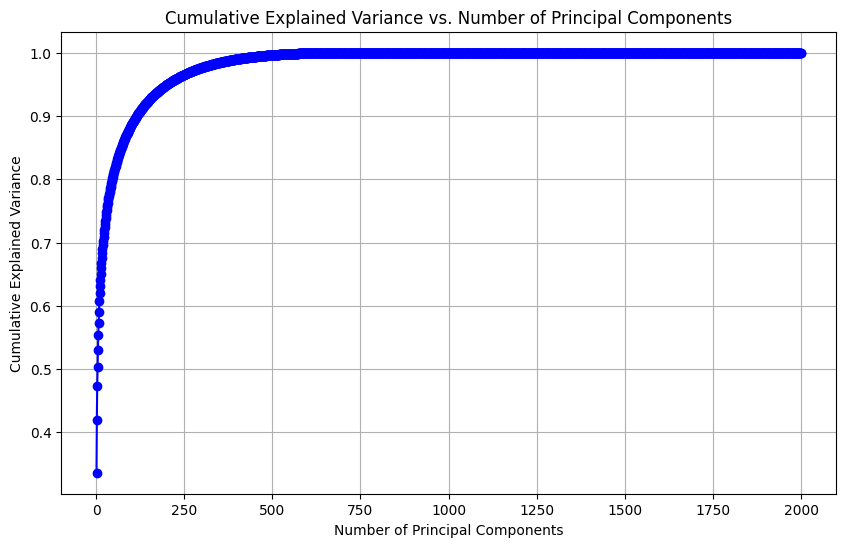

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# TASK 1.1.3

In [24]:
def pca2(input,num_components):
    mean = np.mean(input, axis=0)
    std_dev = np.std(input, axis=0)
    standardized_data = (input - mean)

    cov_matrix = np.cov(standardized_data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvalues = eigenvalues[:num_components]
    selected_eigenvectors = eigenvectors[:, :num_components]

    reduced_data = standardized_data.dot(selected_eigenvectors)
    # print(reduced_data)
    return reduced_data, selected_eigenvalues, selected_eigenvectors

In [25]:
df = np.load('data.npy',allow_pickle=True)
df = pd.DataFrame(df,columns=['game_id','ebd_ResNet','ebd_VIT','Label','TimeStamps'])
labels = np.array(df.iloc[:,3])

df.iloc[:,1] = df.iloc[:,1].map(lambda cell: np.array(cell).flatten(),na_action='ignore')
df.iloc[:,2] = df.iloc[:,2].map(lambda cell: np.array(cell).flatten(),na_action='ignore')
# print(df.iloc[:,1])
# print()
# print(df.iloc[:,2])
labels,frequency = np.unique(labels,return_counts = True)

In [26]:
# for ebd_ResNet

data_1=np.array(np.concatenate(df.iloc[:,1].values).tolist())
data_1 = data_1.reshape(1500,-1)

accuracy = []
precision = []
recall = []
f1score =[]
for i in range(1,1025):
    reduced_data_1, eigenvalues_1, eigenvectors_1 = pca2(data_1, i)
    x_train, x_test, y_train, y_test = train_test_split(reduced_data_1,df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
    distance = ['manhattan', 'cosine', 'euclidean']
    sk_classifier = KNeighborsClassifier(metric = distance[2])
    x_train_list = []
    x_test_list = []
    x_train = np.array(x_train)
    for i in range(len(x_train)):
        x_train_list.append(x_train[i])
    # print(x_train_list)
    x_test = np.array(x_test)
    for i in range(len(x_test)):
        x_test_list.append(x_test[i])
    
    sk_classifier.fit(x_train_list,np.array(y_train))
    y_predicted = sk_classifier.predict(x_test_list)
    accuracy.append(accuracy_score(np.array(y_test),y_predicted))
    f1score.append(f1_score(np.array(y_test),y_predicted, average='weighted',zero_division=1.0))
    precision.append(precision_score(np.array(y_test), y_predicted,average='weighted',zero_division=1.0))
    recall.append(recall_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0))
    # print(reduced_data_1)



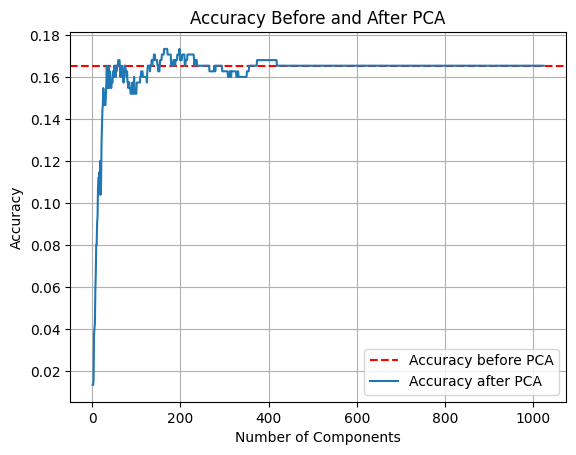

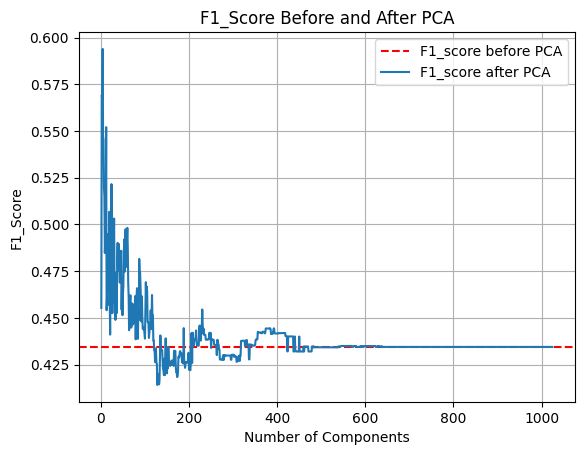

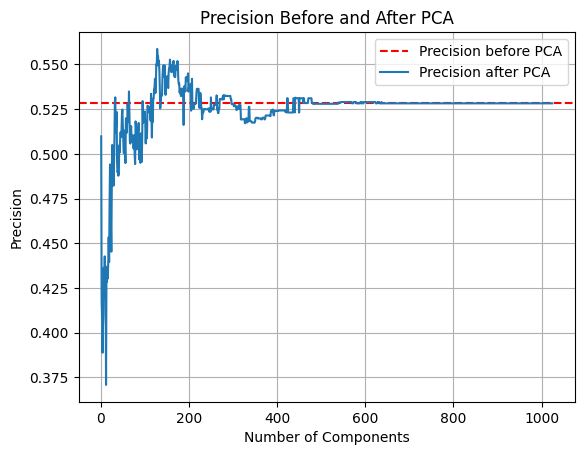

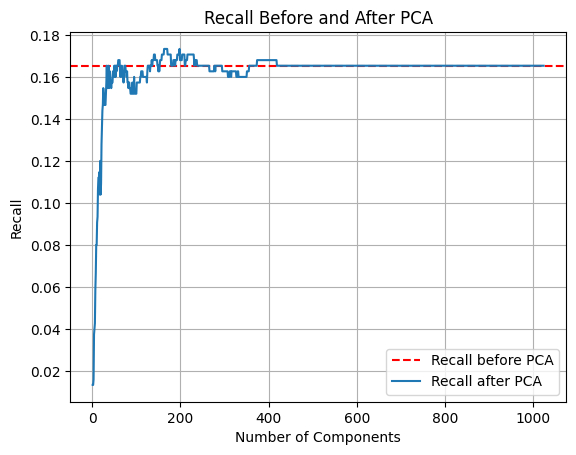

In [27]:
distance = ['manhattan', 'cosine', 'euclidean']
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
sk_classifier = KNeighborsClassifier( metric = distance[2])
x_train_list = []
x_test_list = []
x_train = np.array(x_train)
for i in range(len(x_train)):
    x_train_list.append(x_train[i])
# print(x_train_list)
x_test = np.array(x_test)
for i in range(len(x_test)):
    x_test_list.append(x_test[i])

sk_classifier.fit(x_train_list,np.array(y_train))
y_predicted = sk_classifier.predict(x_test_list)
accuracy_line = accuracy_score(np.array(y_test),y_predicted)
f1score_line = f1_score(np.array(y_test),y_predicted, average='weighted',zero_division=1.0)
precision_line = precision_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0)
recall_line = recall_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0)
# --------------------------------------------------
y_value = accuracy_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Accuracy before PCA')
x_values = np.arange(1, 1025)
plt.plot(x_values, accuracy, label='Accuracy after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# --------------------------------------------------
y_value = f1score_line
plt.axhline(y=y_value, color='red', linestyle='--', label='F1_score before PCA')
x_values = np.arange(1, 1025)
plt.plot(x_values, f1score, label='F1_score after PCA')

plt.xlabel('Number of Components')
plt.ylabel('F1_Score')
plt.title('F1_Score Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# --------------------------------------------------
y_value = precision_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Precision before PCA')
x_values = np.arange(1, 1025)
plt.plot(x_values, precision, label='Precision after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Precision')
plt.title('Precision Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# ---------------------------------------------------
y_value = recall_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Recall before PCA')
x_values = np.arange(1, 1025)
plt.plot(x_values, recall, label='Recall after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Recall')
plt.title('Recall Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()


In [29]:
# for ebd_VIT
data_2=np.array(np.concatenate(df.iloc[:,2].values).tolist())
data_2 = data_2.reshape(1500,-1)

accuracy = []
precision = []
recall = []
f1score =[]
for i in range(1,513):
    reduced_data_2, eigenvalues_2, eigenvectors_2 = pca2(data_2, i)
    x_train, x_test, y_train, y_test = train_test_split(reduced_data_2,df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
    distance = ['manhattan', 'cosine', 'euclidean']
    sk_classifier = KNeighborsClassifier( metric = distance[2])
    x_train_list = []
    x_test_list = []
    x_train = np.array(x_train)
    for i in range(len(x_train)):
        x_train_list.append(x_train[i])
    x_test = np.array(x_test)
    for i in range(len(x_test)):
        x_test_list.append(x_test[i])

        
    sk_classifier.fit(x_train_list,np.array(y_train))
    y_predicted = sk_classifier.predict(x_test_list)
    accuracy.append(accuracy_score(np.array(y_test),y_predicted))
    f1score.append(f1_score(np.array(y_test),y_predicted, average='weighted',zero_division=1.0))
    precision.append(precision_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0))
    recall.append(recall_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0))


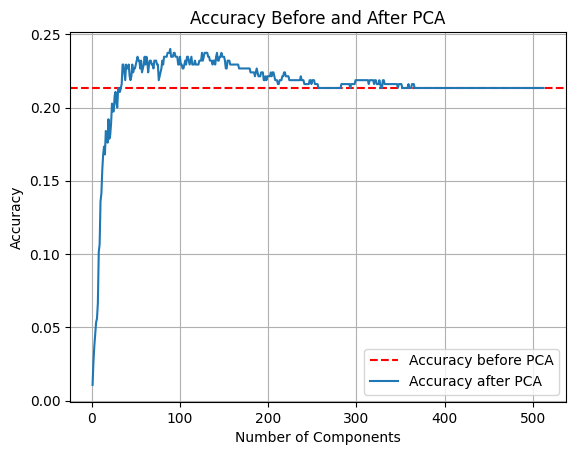

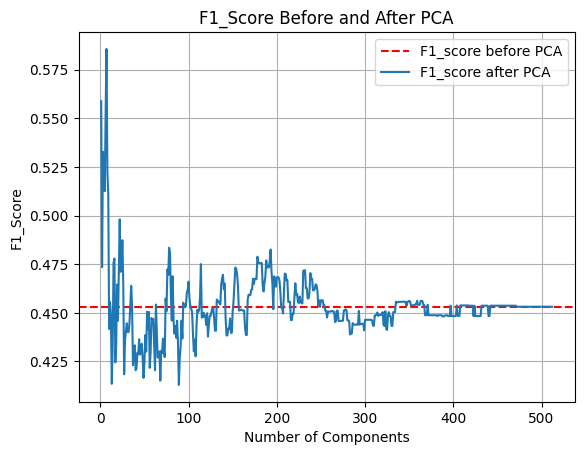

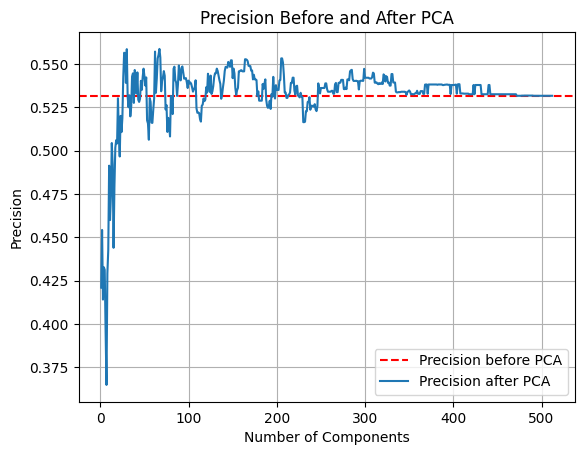

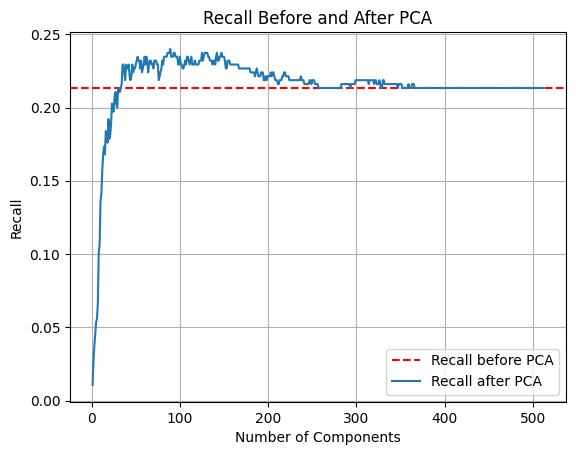

In [30]:
distance = ['manhattan', 'cosine', 'euclidean']
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,2],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
sk_classifier = KNeighborsClassifier( metric = distance[2])
x_train_list = []
x_test_list = []
x_train = np.array(x_train)
for i in range(len(x_train)):
    x_train_list.append(x_train[i])
# print(x_train_list)
x_test = np.array(x_test)
for i in range(len(x_test)):
    x_test_list.append(x_test[i])

sk_classifier.fit(x_train_list,np.array(y_train))
y_predicted = sk_classifier.predict(x_test_list)
accuracy_line = accuracy_score(np.array(y_test),y_predicted)
f1score_line = f1_score(np.array(y_test),y_predicted, average='weighted',zero_division=1.0)
precision_line = precision_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0)
recall_line = recall_score(np.array(y_test),y_predicted,average='weighted',zero_division=1.0)
# --------------------------------------------------
y_value = accuracy_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Accuracy before PCA')
x_values = np.arange(1, 513)
plt.plot(x_values, accuracy, label='Accuracy after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# --------------------------------------------------
y_value = f1score_line
plt.axhline(y=y_value, color='red', linestyle='--', label='F1_score before PCA')
x_values = np.arange(1, 513)
plt.plot(x_values, f1score, label='F1_score after PCA')

plt.xlabel('Number of Components')
plt.ylabel('F1_Score')
plt.title('F1_Score Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# --------------------------------------------------
y_value = precision_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Precision before PCA')
x_values = np.arange(1, 513)
plt.plot(x_values, precision, label='Precision after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Precision')
plt.title('Precision Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# ---------------------------------------------------
y_value = recall_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Recall before PCA')
x_values = np.arange(1, 513)
plt.plot(x_values, recall, label='Recall after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Recall')
plt.title('Recall Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()

The graph shows that as the number of primary components rises, the metric scores move closer to the dataset's initial values. This is because the original features are combined linearly to form the principal components, and as the number of principal components rises, the linear combinations get closer to the original features. Therefore, the metric scores tend to reflect the dataset's initial values. There is a point where adding more principle components causes only a very small change in the metric scores, and the metric scores are virtually converging at this point. The dataset can almost be approximated at this point using just a few main components.

# TASK 1.1.4


In [ ]:

accuracy_cwt = []
# precision_cwt = []
# recall_cwt = []
# f1score_cwt =[]
# num_comp = random.sample(range(1, 3073), 50)
# num_comp = np.sort(num_comp)
reduced_data, eigenvalues, eigenvectors = pca(X, 3072) 
for i in (range(1, 3073)):
    print(reduced_data[:,:i])
    x_train_cwt, x_test_cwt, y_train_cwt, y_test_cwt = train_test_split(reduced_data[:,:i],y , random_state=104,test_size=0.25, shuffle=True)
    distance = ['manhattan', 'cosine', 'euclidean']
    sk_classifier_cwt = KNeighborsClassifier(metric = distance[2])
    x_train_list_cwt = []
    x_test_list_cwt = []
    x_train_cwt = np.array(x_train_cwt)
    for i in range(len(x_train_cwt)):
        x_train_list_cwt.append(x_train_cwt[i])
    # print(x_train_list)
    x_test_cwt = np.array(x_test_cwt)
    for i in range(len(x_test_cwt)):
        x_test_list_cwt.append(x_test_cwt[i])
    
    sk_classifier_cwt.fit(x_train_list_cwt,np.array(y_train_cwt))
    y_predicted_cwt = sk_classifier_cwt.predict(x_test_list_cwt)
    accuracy_cwt.append(accuracy_score(np.array(y_test_cwt),y_predicted_cwt))
    # f1score_cwt.append(f1_score(y_predicted_cwt,np.array(y_test_cwt), average='weighted',zero_division=1.0))
    # precision_cwt.append(precision_score(y_predicted_cwt,np.array(y_test_cwt),average='weighted',zero_division=1.0))
    # recall_cwt.append(recall_score(y_predicted_cwt,np.array(y_test_cwt),average='weighted',zero_division=1.0))

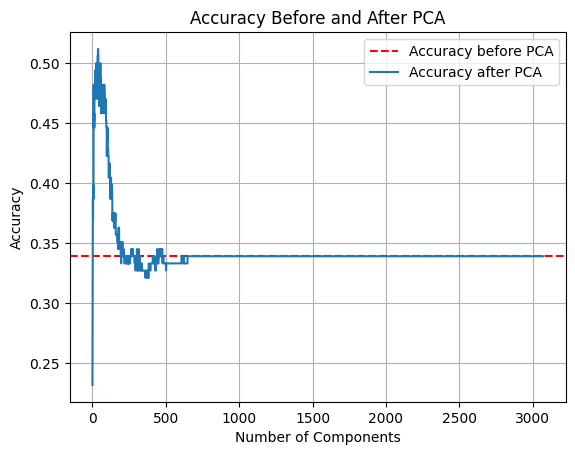

In [19]:
num_images, height, width, channels = X.shape
img_matrix_2d = X.reshape(num_images, -1)  # Reshape to (num_images, height * width * channels)
# print(img_matrix_2d.shape)
distance = ['manhattan', 'cosine', 'euclidean']
x_train, x_test, y_train, y_test = train_test_split(img_matrix_2d,y, random_state=104,test_size=0.25, shuffle=True)
sk_classifier = KNeighborsClassifier(metric = distance[2])
x_train_list = []
x_test_list = []
x_train = np.array(x_train)
for i in range(len(x_train)):
    x_train_list.append(x_train[i])
# print(x_train_list)
x_test = np.array(x_test)
for i in range(len(x_test)):
    x_test_list.append(x_test[i])

sk_classifier.fit(x_train_list,np.array(y_train))
y_predicted = sk_classifier.predict(x_test_list)

accuracy_line = accuracy_score(np.array(y_test),y_predicted)
# f1score_line = f1_score(y_predicted,np.array(y_test), average='weighted',zero_division=1.0)
# precision_line = precision_score(y_predicted,np.array(y_test),average='weighted',zero_division=1.0)
# recall_line = recall_score(y_predicted,np.array(y_test),average='weighted',zero_division=1.0)
# --------------------------------------------------
y_value = accuracy_line
plt.axhline(y=y_value, color='red', linestyle='--', label='Accuracy before PCA')
x_values = range(1, 3073)
plt.plot(x_values, accuracy_cwt, label='Accuracy after PCA')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy Before and After PCA')

plt.legend()
plt.grid(True)
plt.show()
# --------------------------------------------------
# y_value = f1score_line
# plt.axhline(y=y_value, color='red', linestyle='--', label='F1_score before PCA')
# x_values = num_comp
# plt.plot(x_values, f1score_cwt, label='F1_score after PCA')

# plt.xlabel('Number of Components')
# plt.ylabel('F1_Score')
# plt.title('F1_Score Before and After PCA')

# plt.legend()
# plt.grid(True)
# plt.show()
# # --------------------------------------------------
# y_value = precision_line
# plt.axhline(y=y_value, color='red', linestyle='--', label='Precision before PCA')
# x_values = num_comp
# plt.plot(x_values, precision_cwt, label='Precision after PCA')

# plt.xlabel('Number of Components')
# plt.ylabel('Precision')
# plt.title('Precision Before and After PCA')

# plt.legend()
# plt.grid(True)
# plt.show()
# # ---------------------------------------------------
# y_value = recall_line
# plt.axhline(y=y_value, color='red', linestyle='--', label='Recall before PCA')
# x_values = num_comp
# plt.plot(x_values, recall_cwt, label='Recall after PCA')

# plt.xlabel('Number of Components')
# plt.ylabel('Recall')
# plt.title('Recall Before and After PCA')

# plt.legend()
# plt.grid(True)
# plt.show()


As the number of primary components rises, we observe that accuracy tends to return to the dataset's original accuracy, which is consistent with the previous observation. This is thus because the principal components are the linear combinations of the original features, and the linear combinations trend to the original features as the number of main components increases. As a result, the accuracy tends to match the dataset's initial accuracy. There comes a point where adding more principal components causes only a very little change in accuracy, and the accuracy has almost reached convergence. At this stage, using just a handful of principal components, we can virtually perfectly approximate the dataset.

# TASK 1.2

In [33]:
def pca3(input,num_components):
    mean = np.mean(input, axis=0)
    std_dev = np.std(input, axis=0)
    standardized_data = (input - mean)

    cov_matrix = np.cov(standardized_data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvalues = eigenvalues[:num_components]
    selected_eigenvectors = eigenvectors[:, :num_components]

    reduced_data = standardized_data.dot(selected_eigenvectors)
    # print(reduced_data)
    return reduced_data

In [34]:
file_path = "drawer_attributes.csv"
drawer = pd.read_csv(file_path)
file_path = "guesser_attributes.csv"
guesser = pd.read_csv(file_path)
drawer = np.array(drawer) 
guesser = np.array(guesser)
reduced_data_1d = np.array(pca3(drawer, 1))
reduced_data_2d = np.array(pca3(drawer, 2))
reduced_data_3d = np.array(pca3(drawer, 3))

reduced_data_1d_ = np.array(pca3(guesser, 1))
reduced_data_2d_ = np.array(pca3(guesser, 2))
reduced_data_3d_ = np.array(pca3(guesser, 3))


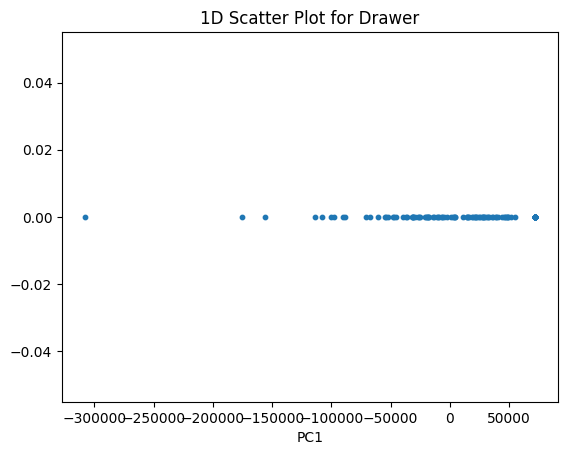

In [35]:
x_values = reduced_data_1d

fig, ax = plt.subplots()

ax.scatter(x_values, np.zeros_like(reduced_data_1d),s=10)  # Use scatter plot for individual data points

ax.set_xlabel('PC1')
ax.set_title('1D Scatter Plot for Drawer')

plt.show()

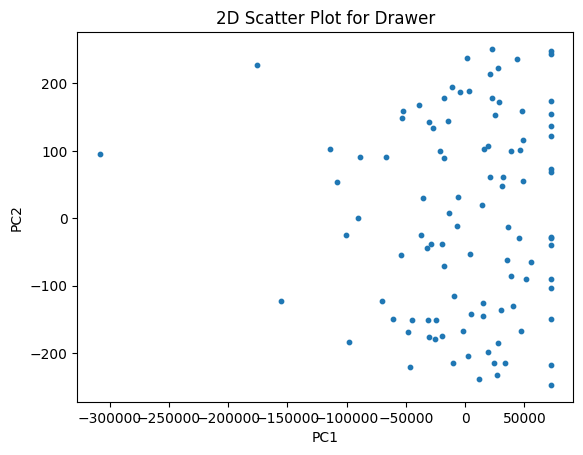

In [36]:
# print(reduced_data_2d)
# print(reduced_data_2d.shape)
x_values = reduced_data_2d[:, 0]  
y_values = reduced_data_2d[:, 1]  

fig, ax = plt.subplots()
ax.scatter(x_values, y_values, s=10)  

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('2D Scatter Plot for Drawer')

plt.show()

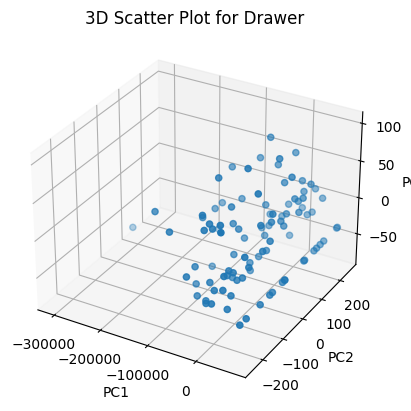

In [37]:
x = reduced_data_3d[:, 0]
y = reduced_data_3d[:, 1]
z = reduced_data_3d[:, 2]
plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Drawer')

plt.show()


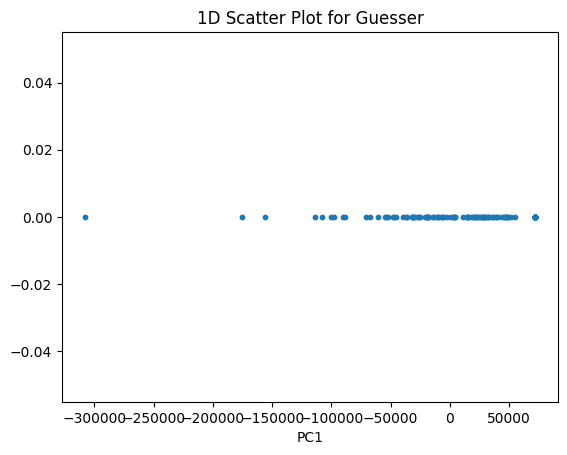

In [38]:
values = reduced_data_1d_

fig, ax = plt.subplots()

ax.scatter(x_values, np.zeros_like(reduced_data_1d_),s=10)  # Use scatter plot for individual data points

ax.set_xlabel('PC1')
ax.set_title('1D Scatter Plot for Guesser')

plt.show()

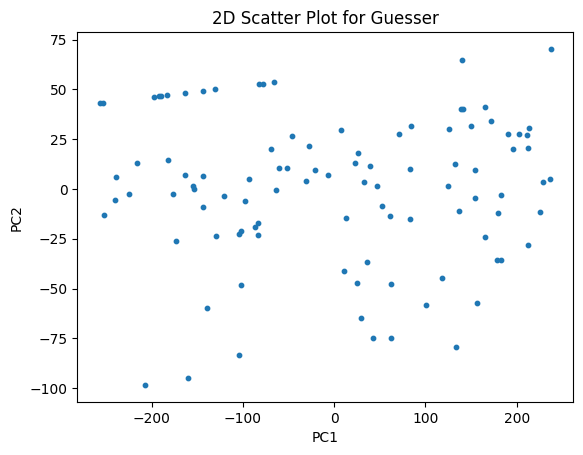

In [39]:
# print(reduced_data_2d)
# print(reduced_data_2d.shape)
x_values = reduced_data_2d_[:, 0] 
y_values = reduced_data_2d_[:, 1]  

fig, ax = plt.subplots()

ax.scatter(x_values, y_values, s=10) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('2D Scatter Plot for Guesser')


plt.show()

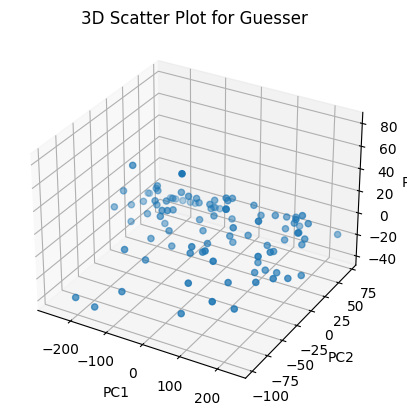

In [40]:
x = reduced_data_3d_[:, 0]
y = reduced_data_3d_[:, 1]
z = reduced_data_3d_[:, 2]
plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot for Guesser')

plt.show()


With the exception of the first, any new axes produced by the PCA indicate a line of maximum variance parallel to the existing axes. As a result, the dataset's maximum variance line serves as the first axis, and the maximum variance line perpendicular to the first axis serves as the second axis, both of which are produced from the PCA. The line of highest variance that runs perpendicular to the first two axes is the third axis that the PCA produces, and so forth. As a result, the first axis derived from the PCA is the most significant axis, followed by the second axis derived from the PCA and so on.